# Implementing word associations with SPA
author: Ivana Kajić (i2kajic@uwaterloo.ca)

Computational simulation of linguistic phenomena requires some kind of a representation of words. In computational investigations, two kinds of representations have been commonly used: semantic networks and vector-based representations.

Each of the representations entails a specific type of data structure and corresponding algorithms that operate on these structures. The final choice of which representation to use depends on the scientific question being asked.

This example uses vector-based representations, which are seen as more biologically plausible due to the way networks of neurons in the brain represent information. In the remainder of this tutorial, an example will be shown of how to represent words and associations with the SPA system.

In [153]:
# Python pacakges for this tutorial

import nengo
import numpy as np
import matplotlib.pyplot as plt

from nengo import spa

## Defining the lexicon and associative relationships

To implement words and word associations, two soruces of data are needed:

- lexicon: a set of words (e.g, `MOUSE`, `HOUSE`, `CAR`)

- associations: associative relationships between the words (e.g., `CAT-MOUSE`, `HOUSE-CAR`)

### Representing Words

For each word in the lexicon, we assign a $n$-dimensional vector, such that every element of a vector is a real number between (-1, 1). In the SPA system, it is common that the similarity between any of the two vectors representing words in a lexicon is less than 0.1 as measured by the dot product.

For a given lexicon of words, a SPA vocabulary containing 64-dimensional vectors for each of the words can be created as:

In [23]:
lexicon = ['HOUSE', 'MOUSE', 'CAT']
vocab = spa.Vocabulary(dimensions=64)

for word in lexicon:
    vocab.parse(word)

We can inspect the contents of a SPA vocabulary:

In [24]:
print 'Words in the vocabulary:', vocab.keys
print 'Dimensionality of vectors:', vocab.vectors.shape

Words in the vocabulary: ['HOUSE', 'MOUSE', 'CAT']
Dimensionality of vectors: (3, 64)


The output of the second line indicates that the three words are stored in three rows and 64 columns (corresponding to 64 dimensions). We will extract this matrix and call it `V`:

In [25]:
V = vocab.vectors
print V[:, :5]  # display only first five columns for legibility

[[ 0.04385886 -0.02819623  0.12032904 -0.00762494 -0.07382352]
 [ 0.01124112 -0.09658684  0.06233474 -0.07492259 -0.05805509]
 [-0.01677367  0.03680834  0.11662219  0.14554526 -0.05508148]]


This matrix is a representation of the lexicon since every row in the matrix can be uniquely mapped to a word in the lexicon.

### Representing word associations

Now, we need to define relationships between words. This can be done in a form of a matrix $A$ containing $m$ rows and $m$ columns, where $m$ corresponds to the number of words in the lexicon ($m=3$ in the previous example).
Thus each row $i$ of a matrix corresponds to $i$-th word in the lexicon, and each column $j$ to the $j$-th word in the lexicon. Then, an association strength between the words $i$ and $j$ is defined as $A_{i,j}$. It is common to refer to the word $i$ as the cue, and the word $j$ as the target.

The most simple implementation of a matrix $A$ is a binary realization, where all $A_{i,j}=1$ can be interpreted as "words $i$ and $j$ are associated" and all $A_{i,j}=0$ as "words $i$ and $j$ are not associated". $A_{i,j}$ can also be a real number, denoting the strength of the associative connection. Thus, larger numbers would correspond to a stronger associative relationship.

For $i=j$ we have an auto-associative relationship as this is the strength of the association of a word with itself. This can be either set to one or zero (depending on the problem). In the following, we will set auto-associations to zero, which will result with a zero diagonal in the $A$ matrix. 

It is important to notice that the matrix A does not have to be symmetric as $A_{i,j} \ne A_{j,i} $. For example, "left" might be associated most strongly with "right", while "right" could have an equally strong association with "correct" and "left".

## Recovering associations of a word

Given the two representations defined in the previos section (matrices $V$ and $A$), we can derive equations that allow us to retrive word vectors that are associated with a given cue. In this example, the cue will be the word CAT.

For example, given the lexicon containing words `['HOUSE', 'MOUSE', 'CAT']` and matrix $A$ defined as

In [26]:
A = np.array([
        [.0, .1, .4],
        [.2, .0, .6],
        [.5, .8, .0]
    ])

we can recover words associated with the word CAT. Ideally the resulting vector would be equal to `0.7*HOUSE + 0.8*MOUSE`, since the association strength between the word CAT and the word HOUSE is `0.7` and the association strength between CAT and MOUSE is `0.8`.
Remember, the vectors HOUSE and MOUSE are farily dissimilar (as their dot product is below 0.1) so we can  recover the association strengths from the resulting vector by multiplying it with either CAT or MOUSE.

Before providing equations that realize this process, let us consider a (hopefully) intuitive explanation of what is happening. In the following example, we will assume a cue vector that represents the word CAT and we would like to know what words are associated with CAT.

First, we multiply the cue vector with the matrix $V$. This results in a new n-dimensional vector where all entries but a single one are less than 0.1. This because the similarity between any two vectors in the vocabulary is less than 0.1. The single entry that is not 0.1 is equal to or close to 1, as that entry represents a dot product between the vector CAT and the cue vector (which we set to CAT).

In [27]:
cue = vocab['CAT'].v       # extract vector for CAT from the vocabulary
result = np.dot(V, cue)    # multiply it from the right
result

array([ 0.02292477,  0.03275846,  1.        ])

The resulting vector can be seen as an indexing vector: it will have "1" only at the position corresponding to the index of the cue word in the lexicon (in our case, CAT was the third word) and approximately all zeros elsewhere. Now, we need to "extract" the row of a matrix $A$ that corresponds to the position of "1"  in the indexing vector. This is the same as extracting association strengths of words associated with CAT.

To do so, we multiply the resulting vector with with $A^T$. The transpose is necessary because associations are encoded as $A_{i,j}$ where $i$ is the cue word, and $j$ is the target. If we multiplied the matrix $A$ with the vector `result`, we would extract the column of the matrix $A$ instead of a row (if this is still confusing, try multiplying A with [0, 0, 1] and then A.T with the same vector to see which one extracts the row).

In [28]:
assoc = np.dot(A.T, result)
print assoc

[ 0.50655169  0.80229248  0.02882498]


At this point we have extracted association strengths and now we can use them to recover the word vectors in the vocabulary. Each vector in the vocabulary will be multiplied by the corresponding strength, yielding a final vector that will be a linear combination of all vectors. However, vectors with low association strengths will be essentially mutliplied by zero, contributing little to the final representation. 

We can denote the final vector with:

In [29]:
final = np.dot(V.T, assoc)

and explore its similarity with all vectors in the vocabulary:

In [31]:
vec_sim = np.dot(V, final)
print vec_sim

[ 0.52441166  0.81409595  0.06671943]


The resulting similarities can be interpreted in the following way:

In [32]:
for i, word in enumerate(lexicon):
    print 'The similarity between the word CAT and', word, 'is:', vec_sim[i]

The similarity between the word CAT and HOUSE is: 0.524411661452
The similarity between the word CAT and MOUSE is: 0.814095952626
The similarity between the word CAT and CAT is: 0.0667194267228


After inspecting the third row of the matrix $A$:

In [34]:
A[2]

array([ 0.5,  0.8,  0. ])

We can notice that the recovered association strengths are very close to the ones defined by the matrix $A$. The noise in the representation comes from vectors which are to some extent overlapping and can be reduced by enforcing a lower similarity constraint.

Finally, the process leading to the final vector $v$ can be expressed as $V^T A^T V$ where the final vector $v$ is obtained by mutliplying the expression with the cue vector $c$ from the right: $v=V^T A^T V c$.

## Nengo Implementation

The example provided so far can be easily implemented in Nengo. Connections between neurons are used to implement transformations.

Therefore, we can define two populations of neurons *cue* and *target* and implement the expression $V^T A^T V$ as the transformation between the two populations:


In [101]:
d = 64
with spa.SPA('Associations') as model:
    model.cue = spa.State(vocab=vocab, dimensions=d)
    model.target = spa.State(vocab=vocab, dimensions=d)

    nengo.Connection(model.cue.output,
                     model.target.input,
                     transform=np.dot(V.T, np.dot(A.T, V))
                    )

After we have defined the model, we can present the word CAT at the input and run the model:

In [102]:
def f_input(t):
    if 0 < t < 0.5:
        return 'CAT'
    elif 0.5 < t < 1.0:
        return 'MOUSE'
    else:
        return 'HOUSE'

with model:
    model.inp = spa.Input(cue=f_input)
    cue_probe = nengo.Probe(model.cue.input)
    target_probe = nengo.Probe(model.target.input)

In [108]:
with nengo.Simulator(model) as sim:
    sim.run(1.5) # Run simulator for 2 seconds

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:02.                                                 


In [109]:
t = sim.trange()

input_data = sim.data[cue_probe]
output_data = sim.data[target_probe]

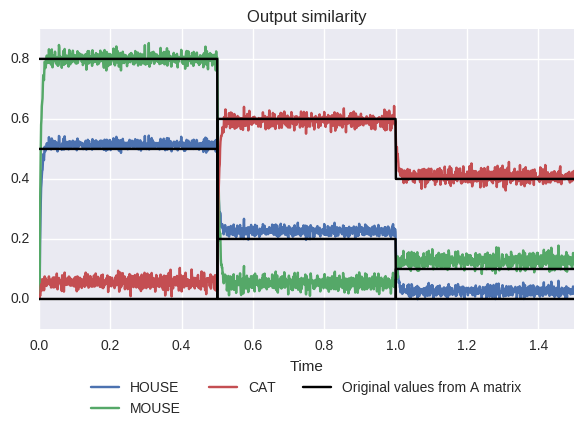

In [155]:
ymin, ymax = -1.2, 1.2
plt.figure(figsize=(6, 4))

true = np.ones((len(t), 3))
true[:500] *= A[2]
true[500:1000] *= A[1]
true[1000:] *= A[0]

plt.plot(t, spa.similarity(output_data, vocab))
plt.plot(t, true, color='k')
plt.title("Output similarity")
plt.xlabel("Time")
plt.xlim(right=t[-1])
plt.ylim(ymin, ymax)
plt.autoscale(True, axis='y')
plt.grid(True)
plt.legend(
    vocab.keys+['Original values from A matrix'], loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=3)
plt.tight_layout()
plt.show()